In [46]:
import torch
import torch.nn as nn
import csv
import gzip
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as T
import numpy as np
import pandas as pd
import time
import wandb
import os, sys, glob
from sklearn.metrics import f1_score, accuracy_score
import ipdb
import pathlib
import tifffile
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from os.path import dirname, join, abspath
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
%load_ext autoreload
%autoreload 2
from utils import ProgressMeter, AverageMeter, save_checkpoint, MultiEpochsDataLoader, TensorDatasetMIL, collate_fn_MIL, remove_part_by_negative_index, get_percentiles_normalize, PercentileNormalize
from models.abmil import ABMIL
from models.amlab_mil import Attention, GatedAttention


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
files_path = "/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/histoprep_embeddings_uni/224/0_25_28"
cores_directories = []
slides_directories = [d for d in os.listdir(files_path) if
                     os.path.isdir(os.path.join(files_path, d)) and d.startswith('TMA')]
for i, slide in enumerate(slides_directories):
    slide_files_path = str(files_path) + "/" + slide
    for r, ds, fs in os.walk(slide_files_path):
        for dn in ds:
            if dn.startswith('core'):
                patches_files = [file for file in os.listdir(os.path.join(r, dn))]
                cores_directories.append(os.path.join(r, dn))
cores_chemo_labels_df = pd.read_csv('../data/cores_labels_chemotherapy.csv')
batch_size = 1
input_dimensions = None
classifier_model = Attention(encoding='trainable', input_dim=input_dimensions)
checkpoint = torch.load('../saved_models/model_best_embedding_nact_mil_fullcore_0_25_28_encoder_trainable_filterlowcancercells_False_imagenormalization_True.pth.tar')
classifier_model.load_state_dict(checkpoint['state_dict'])
classifier_model.eval()
#classifier_model = classifier_model.to('cuda')

Attention(
  (feature_extractor_part1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature_extractor_part2): Sequential(
    (0): Linear(in_features=140450, out_features=500, bias=True)
    (1): ReLU()
  )
  (attention): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=500, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [49]:
labels_train = []
labels_test = []
labels_validate = []
channels = [0, 25, 28]
# Only files that we have a label for
cores_train = []
cores_test = []
for i, core_directory in enumerate(cores_directories):
    patch_file_label_df = cores_chemo_labels_df[(cores_chemo_labels_df['cycif.slide']==core_directory.split('/')[-2])&(cores_chemo_labels_df['cycif.core.id']==core_directory.split('/')[-1])]
    # if core_file_stats is empty, we assume that there is no cancer cells in the core and we should skip it
    # Ignore labels with PDS followed by NACT
    if not patch_file_label_df.empty and str(patch_file_label_df.iloc[0]['therapy_sequence']).lower()!='na' and not pd.isnull(patch_file_label_df.iloc[0]['therapy_sequence'])\
            and not patch_file_label_df.iloc[0]['therapy_sequence'] == 'PDS followed by NACT':
        # ignore images with nan
        if core_directory.split('/')[-2]=='TMA_45_312' or core_directory.split('/')[-2]=='TMA_46_325':
            cores_test.append(core_directory)
            # If contains NACT, is a sample collected after chemotherapy exposure
            if 'nact' in str(patch_file_label_df.iloc[0]['therapy_sequence']).lower():
                labels_test.append(1)
            else:
                labels_test.append(0)
        else:#if core_file.split('/')[-3]=='TMA_44_810' or core_file.split('/')[-3]=='TMA_45_312':
            cores_train.append(core_directory)
            # If contains NACT, is a sample collected after chemotherapy exposure
            if 'nact' in str(patch_file_label_df.iloc[0]['therapy_sequence']).lower():
                labels_train.append(1)
            else:
                labels_train.append(0)
    else:
        print('Missing label for:'+core_directory)
raw_cores_train = [core.replace('histoprep_embeddings_uni','histoprep_generated').replace('/'+'_'.join(str(channel) for channel in channels),'') for core in cores_train]
raw_cores_test = [core.replace('histoprep_embeddings_uni', 'histoprep_generated').replace('/'+'_'.join(str(channel) for channel in channels), '') for core
                   in cores_test]
#percentile_1, percentile_99 = get_percentiles_normalize(raw_cores_train+raw_cores_test, channels)
percentile_min = np.array([0]*len(channels))
percentile_max = np.array([65535] * len(channels))
normalize_transform = PercentileNormalize(percentile_min, percentile_max)
transforms_train = normalize_transform
transforms_test = normalize_transform
tensor_dataset_train = TensorDatasetMIL(slides=cores_train,transform=transforms_train,labels=labels_train,raw_images=raw_cores_train, gigapath=False,channels=channels)
tensor_dataset_test = TensorDatasetMIL(slides=cores_test,transform=transforms_test, labels=labels_test, raw_images=raw_cores_test,gigapath=False,channels=channels)
#tiff_dataset_validate = TiffDataset(files=cores_files_validate, transform=transforms, channels=channels,labels=cores_labels_validate)
train_sampler = None
train_loader = MultiEpochsDataLoader(
        tensor_dataset_train, batch_size=batch_size, shuffle=False,
         pin_memory=True, sampler=train_sampler, collate_fn=None)
test_sampler = None
test_loader = MultiEpochsDataLoader(
        tensor_dataset_test, batch_size=batch_size, shuffle=False,
         pin_memory=True, sampler=test_sampler, collate_fn=None)

Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/histoprep_embeddings_uni/224/0_25_28/TMA_46_325/core4
Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/histoprep_embeddings_uni/224/0_25_28/TMA_46_325/core2
Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/histoprep_embeddings_uni/224/0_25_28/TMA_46_325/core1
Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/histoprep_embeddings_uni/224/0_25_28/TMA_46_325/core45
Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/histoprep_embeddings_uni/224/0_25_28/TMA_46_325/core42
Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/histoprep_embeddings_uni/224/0_25_28/TMA_46_325/core3
Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/histoprep_embeddings_uni/224/0_25_28/TMA_42_961/core70
Missing label for:/data/projects/pixel_project/datas

Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/histoprep_embeddings_uni/224/0_25_28/TMA_44_810/core80


In [108]:
labels = 0
while labels ==0:
    images, raw_images,labels, files_names = next(iter(test_loader))

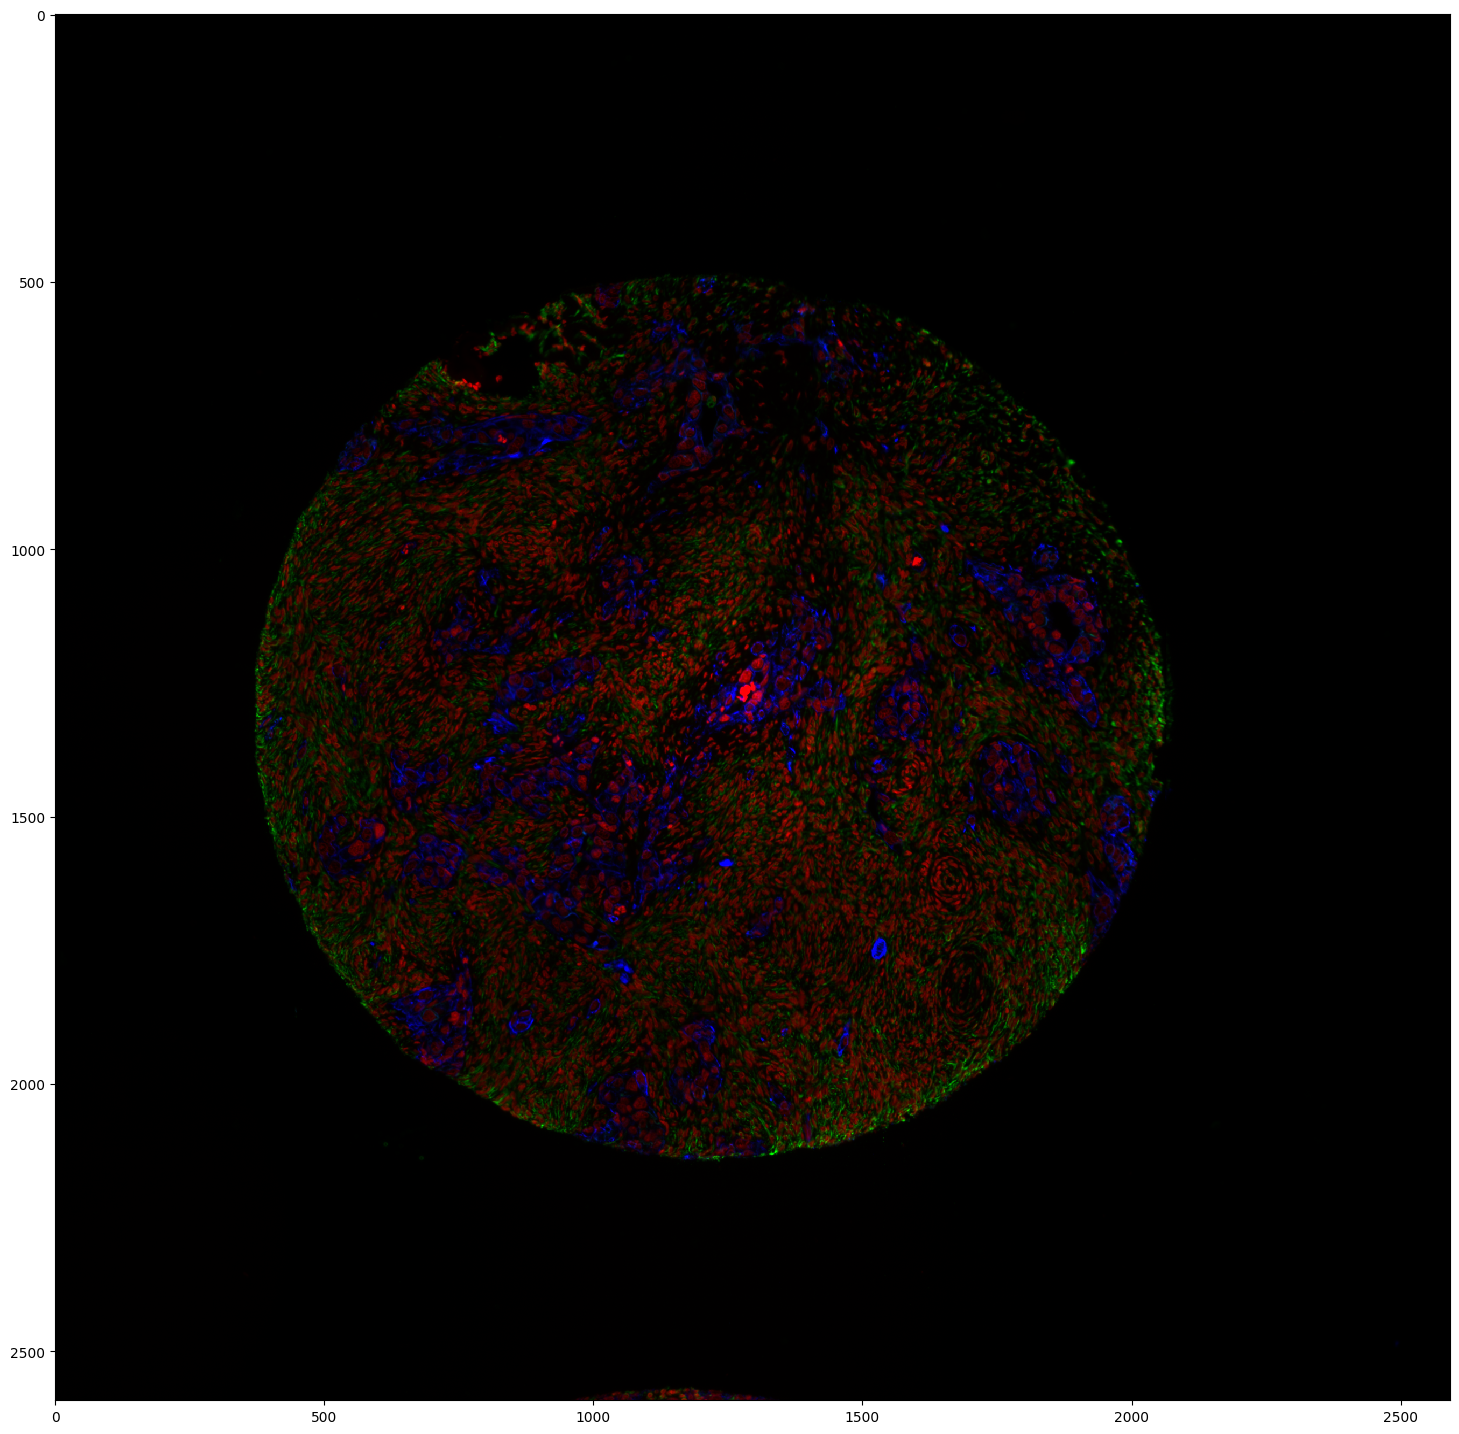

In [120]:
file_name = '/data/projects/pixel_project/datasets/NKI_project_TMAs/{0}/Channels_all/{1}.tif'.format(files_names[0][0].split('/')[-3],files_names[0][0].split('/')[-2])
im_tiff = tifffile.imread(file_name,key=channels,maxworkers=32)
info = np.iinfo(im_tiff.dtype)
sample = torch.from_numpy(im_tiff/ info.max).float()
plt.figure(figsize=(18, 18))
plt.imshow(sample.permute(1, 2, 0), interpolation='nearest', aspect='auto')
plt.show()

In [116]:
patch_file_label_df = cores_chemo_labels_df[(cores_chemo_labels_df['cycif.slide']==files_names[0][0].split('/')[-3])&(cores_chemo_labels_df['cycif.core.id']==files_names[0][0].split('/')[-2])]
patch_file_label_df

cycif.slide cycif.core.id    patient Molecular.profile2 figo_stage  \
289  TMA_46_325        core50  T12-11980                HRD    FIGO IV   

                  therapy_sequence  finalstatus  timelastfu  \
289  NACT followed by re-debulking          2.0       509.0   

     daystoprogression  progression  
289              451.0          1.0

In [112]:
labels

tensor([1.])

In [117]:
with torch.no_grad():
    Y_prob,_, attention_weights = classifier_model(raw_images)
    print(Y_prob, attention_weights)

tensor([[0.0804]]) tensor([[4.9821e-04, 1.3615e-04, 3.5958e-04, 4.3893e-03, 1.3918e-02, 4.3456e-04,
         2.5279e-04, 3.4291e-04, 9.2784e-04, 1.0041e-04, 1.7663e-03, 2.8155e-04,
         1.0445e-03, 1.7769e-04, 8.9542e-01, 8.7160e-04, 1.5477e-04, 1.4909e-04,
         4.0308e-04, 6.2425e-04, 9.8203e-04, 2.6985e-04, 1.7844e-04, 4.6763e-03,
         1.9350e-03, 4.2803e-03, 3.5065e-04, 1.5491e-03, 2.4884e-04, 7.2482e-05,
         7.9137e-03, 3.0428e-04, 6.6610e-04, 2.8580e-02, 8.1589e-05, 3.5207e-03,
         1.9608e-03, 8.6342e-05, 6.4121e-05, 2.3615e-04, 9.3118e-05, 7.5064e-04,
         1.5710e-04, 5.0199e-04, 1.0569e-04, 4.3690e-05, 1.8631e-04, 1.6772e-04,
         1.0730e-04, 7.0558e-05, 2.2548e-04, 2.5498e-04, 1.4604e-04, 8.5398e-05,
         1.6138e-02, 7.5336e-04]])


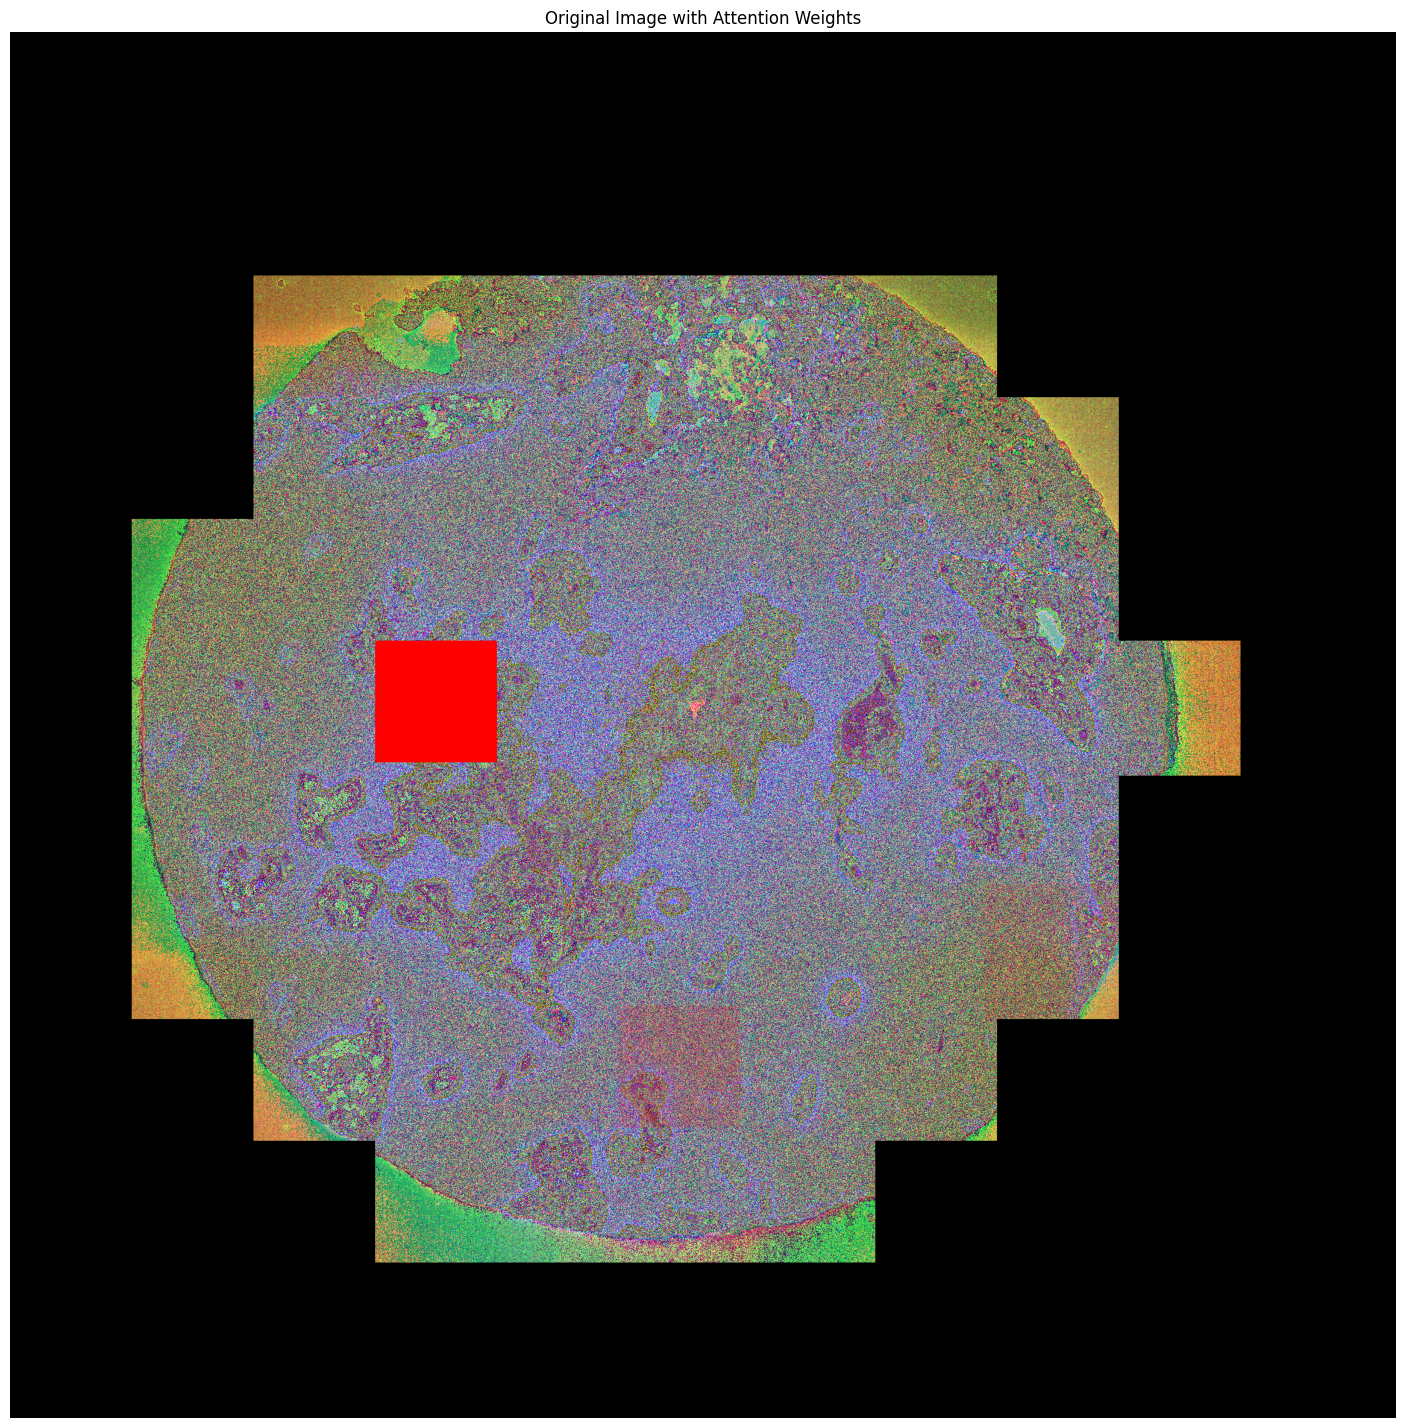

In [118]:
tile_size = 224
height = 2300
width = 2300
original_image = np.zeros((height, width, 3), dtype=np.uint8)
# Place each tile at the correct position
for image, raw_image, file_name, attention_weight in zip(images[0], raw_images[0], files_names, attention_weights[0]):
    start_y = int(file_name[0].split('/')[-1].split('_')[1])
    start_x = int(file_name[0].split('/')[-1].split('_')[2])
    end_x = start_x + tile_size
    end_y = start_y + tile_size
    # Place the tile on the original image
    original_image[start_y:end_y, start_x:end_x] = np.transpose(np.squeeze(raw_image*65535), (1, 2, 0))


    # Overlay the attention weight
    alpha = 5  # Transparency factor for the overlay
    overlay = np.full((tile_size, tile_size, 3), (255, 0, 0), dtype=np.uint8)  # Red color for attention
    cv2.addWeighted(overlay, alpha * attention_weight.item(), original_image[start_y:end_y, start_x:end_x], 1 - alpha * attention_weight.item(), 0, original_image[start_y:end_y, start_x:end_x])
plt.figure(figsize=(18, 18))
plt.imshow(original_image)
plt.axis('off')
plt.title('Original Image with Attention Weights')
plt.show()

In [60]:
np.squeeze(raw_image).shape

torch.Size([58, 3, 224, 224])

In [72]:
binary_predictions_list = []
labels_predictions = []
for epoch in range(1):
    for i, (bag_tensor,raw_images, labels, files_names) in enumerate(test_loader):
        with torch.no_grad():
            loss, attention_weights = classifier_model.calculate_objective(raw_images, labels, eval_mode=True)
            error, binary_predictions = classifier_model.calculate_classification_error(raw_images, labels,eval_mode=True)
            binary_predictions = binary_predictions.cpu().tolist()
            binary_predictions_list.extend(binary_predictions)
            labels_predictions.extend(labels.cpu())

In [73]:
classifier_model.calculate_classification_error(raw_images, labels,eval_mode=True)

(0.0, tensor([[1.]]))

In [74]:
# Model after running on test epoch 1 time, to see if it results change, (they didnt)
accuracy_value = accuracy_score(labels_predictions, binary_predictions_list)
f1_value = f1_score(labels_predictions, binary_predictions_list, average='macro')
print('Accuracy:'+str(accuracy_value))
print('F1:'+str(f1_value))

Accuracy:0.8227848101265823
F1:0.8225288831835686


In [75]:
# Model after running on test epoch 30 times, to see if it results change, (they didnt)
accuracy_value = accuracy_score(labels_predictions, binary_predictions_list)
f1_value = f1_score(labels_predictions, binary_predictions_list, average='macro')
print('Accuracy:'+str(accuracy_value))
print('F1:'+str(f1_value))

Accuracy:0.8227848101265823
F1:0.8225288831835686


In [47]:
def sum_params(model):
    s = []
    for p in model.parameters():
        dims = p.size()
        n = p.cpu().data.numpy()
        s.append((dims, np.sum(n)))
    return s



In [50]:
params_list = sum_params(classifier_model)

In [53]:
#Params after 1 run
sum([param[1] for param in params_list])

-2.7208541044965386

In [56]:
# Params after 30 epochs (didnt change)
params_list = sum_params(classifier_model)
print(sum([param[1] for param in params_list]))

-2.7208541044965386


In [122]:
# Test model on Inga-Maria data, PDS all patients, unseen data by the model
channels_launonen = [0, 30, 34]
files_path = "/data/projects/pixel_project/datasets/Launonen_TMA/patches/histoprep_embeddings_uni/224/0_30_34"
cores_directories = []
slides_directories = ["/data/projects/pixel_project/datasets/Launonen_TMA/patches/histoprep_embeddings_uni/224/0_30_34/TMA1"]
for i, slide in enumerate(slides_directories):
    for r, ds, fs in os.walk(slide):
        for dn in ds:
            if dn.startswith('core'):
                patches_files = [file for file in os.listdir(os.path.join(r, dn))]
                cores_directories.append(os.path.join(r, dn))

In [123]:
raw_cores = [core.replace('histoprep_embeddings_uni','histoprep_generated').replace('/'+'_'.join(str(channel) for channel in channels_launonen),'') for core in cores_directories]
percentile_1, percentile_99 = get_percentiles_normalize(raw_cores, channels_launonen)
normalize_transform = PercentileNormalize(percentile_1, percentile_99)
transforms_train = normalize_transform

In [124]:
cores_test = []
labels_test = []
for i, core_directory in enumerate(cores_directories):
    cores_test.append(core_directory)
    labels_test.append(0)
tensor_dataset_test = TensorDatasetMIL(slides=cores_test,transform=transforms_train, labels=labels_test, gigapath=False,multi_channels=None, channels=channels_launonen, raw_images=raw_cores)
test_loader = MultiEpochsDataLoader(
            tensor_dataset_test, batch_size=1, shuffle=False,
             pin_memory=True, sampler=None, num_workers=4, collate_fn=None)

In [125]:
binary_predictions_list = []
labels_predictions = []
losses = AverageMeter('Loss', ':.20f')
data_time = AverageMeter('Data', ':6.3f')
classifier_model = classifier_model.cuda()
for i, (bag_tensor, raw_images, labels, files_names) in enumerate(test_loader):
    raw_images = raw_images.cuda()
    #mask = mask.cuda()
    labels = labels.cuda()

    with torch.no_grad():
        loss, attention_weights = classifier_model.calculate_objective(raw_images, labels, eval_mode=True)
        error, binary_predictions = classifier_model.calculate_classification_error(raw_images, labels,eval_mode=True)

    binary_predictions = binary_predictions.cpu().tolist()
    # Compute loss

    losses.update(loss.item(), bag_tensor.size(0))
    binary_predictions_list.extend(binary_predictions)
    labels_predictions.extend(labels.cpu())
    #if i % 100 == 0:
    end = time.time()
    data_time.update(time.time() - end)
accuracy_value = accuracy_score(labels_predictions, binary_predictions_list)
f1_value = f1_score(labels_predictions, binary_predictions_list, average='macro')
print(f1_value)

0.4398496240601504


In [126]:
binary_predictions_list

[[0.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],


In [127]:
accuracy_value

0.785234899328859

In [89]:
labels_predictions

[tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),